# Nonlinear Regression with Dictionary Learning

This notebook shows how to use **dictionary expansion** to fit nonlinear functions
using linear regression (`AILibs.linear_regression.lr_fit`).

The idea: expand features into a richer dictionary, then solve $Y = X_{\text{aug}} \cdot A$ with linear least-squares.

Available dictionaries:
- `dictionary_constant` — bias / intercept term
- `dictionary_polynomial` — powers $x^2, x^3, \ldots$
- `dictionary_cross_products` — pairwise products $x_i \cdot x_j$
- `dictionary_sin_cos` — sine / cosine harmonics
- `dictionary_sin_cos_cross` — $x_a \sin(x_b)$, $x_a \cos(x_b)$

In [1]:
import numpy
import matplotlib.pyplot as plt

import AILibs

rng = numpy.random.default_rng(42)

## 1. 1D Polynomial Fit

Fit $y = 0.5 x^3 - 3 x^2 + 3 x + 1$ using a polynomial dictionary up to order 3.

In [2]:
# generate data
n_samples = 1000
x_1d = rng.uniform(-3, 3, (n_samples, 1))
y_1d = 0.5 * x_1d**3 - 1.0 * x_1d**2 + 0.3 * x_1d + 1.0 + rng.normal(0, 1.0, (n_samples, 1))



# build augmented features: [x, 1, x^2, x^3]
x_const = AILibs.common.dictionary.dictionary_constant(x_1d)
x_poly  = AILibs.common.dictionary.dictionary_polynomial(x_1d, order=3)
x_aug   = numpy.concatenate([x_1d, x_const, x_poly], axis=1)

print(f"Original features: {x_1d.shape[1]}")
print(f"Augmented features: {x_aug.shape[1]}  (x, 1, x², x³)")

# fit
a_est = AILibs.linear_regression.lr_fit(x_aug, y_1d)
y_pred = x_aug @ a_est

metrics = AILibs.metrics.regression_evaluation(y_1d, y_pred)
print(f"\nR² = {metrics['r2']:.5f}")
print(f"Estimated coefficients: {a_est.flatten()}")
print(f"True coefficients:      [3.0, 1.0, -2.0, 0.5]")

Original features: 1
Augmented features: 4  (x, 1, x², x³)

R² = 0.97502
Estimated coefficients: [ 0.35598273  0.96574654 -1.01415548  0.49579402]
True coefficients:      [3.0, 1.0, -2.0, 0.5]


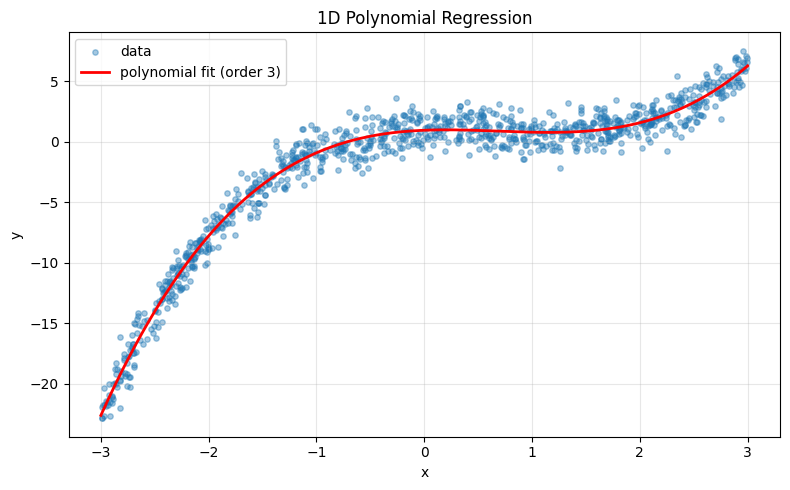

In [3]:
# plot
x_plot = numpy.linspace(-3, 3, n_samples).reshape(-1, 1)
x_plot_aug = numpy.concatenate([
    x_plot,
    AILibs.common.dictionary.dictionary_constant(x_plot),
    AILibs.common.dictionary.dictionary_polynomial(x_plot, order=3)
], axis=1)
y_plot = x_plot_aug @ a_est

plt.figure(figsize=(8, 5))
plt.scatter(x_1d, y_1d, alpha=0.4, s=15, label="data")
plt.plot(x_plot, y_plot, color="red", linewidth=2, label="polynomial fit (order 3)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("1D Polynomial Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. 1D Sinusoidal Fit

Fit a function composed of sine/cosine harmonics using `dictionary_sin_cos`.

In [4]:
# true function: y = 2*sin(x) - 0.5*cos(3x) + 1
n_samples = 1000
x_sin = rng.uniform(-numpy.pi, numpy.pi, (n_samples, 1))
y_sin = 2.0 * numpy.sin(1.7*x_sin) - 3.5 * numpy.cos(3 * x_sin) + 1.0 + rng.normal(0, 1.0, (n_samples, 1))

# augmented dictionary: [x, 1, sin(x), cos(x), sin(2x), cos(2x), ..., sin(5x), cos(5x)]
x_sin_const = AILibs.common.dictionary.dictionary_constant(x_sin)
x_sin_harm  = AILibs.common.dictionary.dictionary_sin_cos(x_sin, n_harmonics=5)
x_sin_aug   = numpy.concatenate([x_sin, x_sin_const, x_sin_harm], axis=1)

print(f"Augmented features: {x_sin_aug.shape[1]}")

a_sin = AILibs.linear_regression.lr_fit(x_sin_aug, y_sin)
y_sin_pred = x_sin_aug @ a_sin

metrics_sin = AILibs.metrics.regression_evaluation(y_sin, y_sin_pred)
print(f"R² = {metrics_sin['r2']:.5f}")

Augmented features: 12
R² = 0.89158


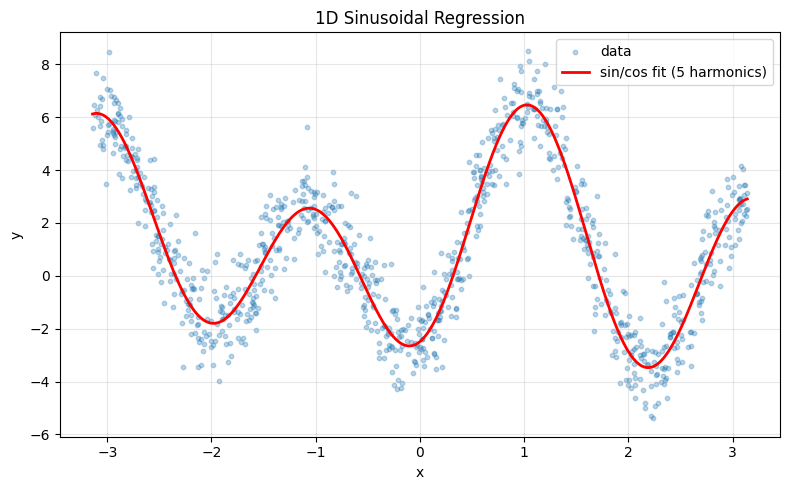

In [5]:
x_plot_s = numpy.linspace(-numpy.pi, numpy.pi, n_samples).reshape(-1, 1)
x_plot_s_aug = numpy.concatenate([
    x_plot_s,
    AILibs.common.dictionary.dictionary_constant(x_plot_s),
    AILibs.common.dictionary.dictionary_sin_cos(x_plot_s, n_harmonics=5)
], axis=1)
y_plot_s = x_plot_s_aug @ a_sin

plt.figure(figsize=(8, 5))
plt.scatter(x_sin, y_sin, alpha=0.3, s=10, label="data")
plt.plot(x_plot_s, y_plot_s, color="red", linewidth=2, label="sin/cos fit (5 harmonics)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("1D Sinusoidal Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Comparing Dictionary Orders (Polynomial)

Show underfitting vs. good fit vs. overfitting by varying polynomial order.

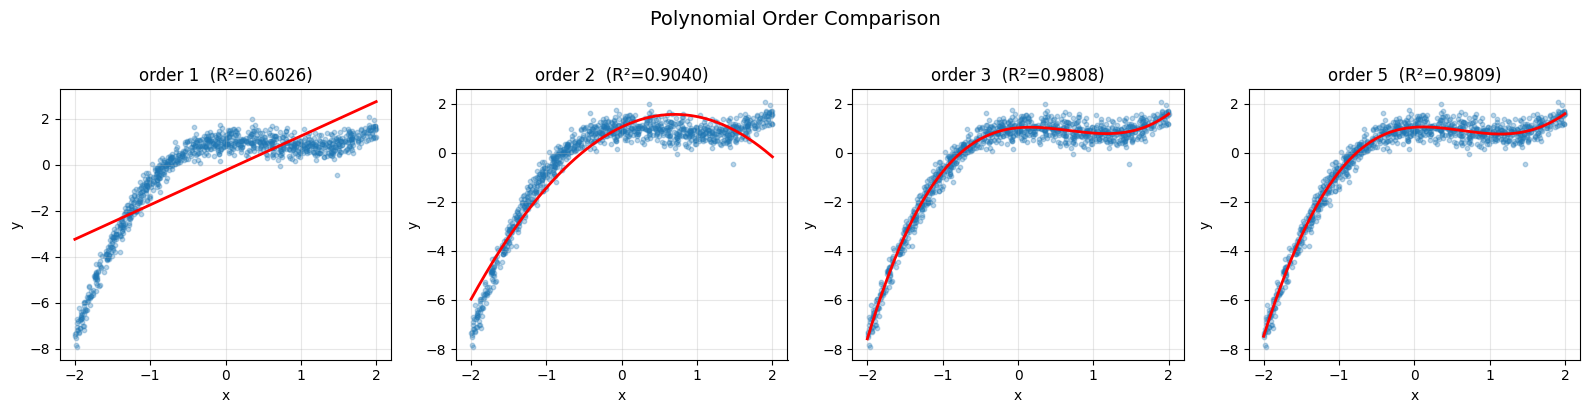

In [6]:
orders = [1, 2, 3, 5]
n_samples = 1000
x_cmp = rng.uniform(-2, 2, (n_samples, 1))
y_cmp = 0.5 * x_cmp**3 - x_cmp**2 + 0.3 * x_cmp + 1 + rng.normal(0, 0.3, (n_samples, 1))

x_plot_c = numpy.linspace(-2, 2, n_samples).reshape(-1, 1)

fig, axes = plt.subplots(1, len(orders), figsize=(4 * len(orders), 4))

for idx, order in enumerate(orders):    
    # build augmented features
    if order == 1:
        x_a = numpy.concatenate([x_cmp, AILibs.common.dictionary.dictionary_constant(x_cmp)], axis=1)
        x_p = numpy.concatenate([x_plot_c, AILibs.common.dictionary.dictionary_constant(x_plot_c)], axis=1)
    else:
        x_a = numpy.concatenate([
            x_cmp,
            AILibs.common.dictionary.dictionary_constant(x_cmp),
            AILibs.common.dictionary.dictionary_polynomial(x_cmp, order=order)
        ], axis=1)
        x_p = numpy.concatenate([
            x_plot_c,
            AILibs.common.dictionary.dictionary_constant(x_plot_c),
            AILibs.common.dictionary.dictionary_polynomial(x_plot_c, order=order)
        ], axis=1)

    a_c = AILibs.linear_regression.lr_fit(x_a, y_cmp)
    y_p = x_p @ a_c
    y_fit = x_a @ a_c
    m = AILibs.metrics.regression_evaluation(y_cmp, y_fit)

    axes[idx].scatter(x_cmp, y_cmp, alpha=0.3, s=10)
    axes[idx].plot(x_plot_c, y_p, color="red", linewidth=2)
    axes[idx].set_title(f"order {order}  (R²={m['r2']:.4f})")
    axes[idx].set_xlabel("x")
    axes[idx].set_ylabel("y")
    axes[idx].grid(True, alpha=0.3)

plt.suptitle("Polynomial Order Comparison", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 4. Multi-Dimensional with Cross Products

Use `dictionary_cross_products` to capture interaction effects between features.

In [7]:
n_inputs = 5
n_samples = 1000

x_cp = rng.standard_normal((n_samples, n_inputs))

# build full dictionary
x_const_cp = AILibs.common.dictionary.dictionary_constant(x_cp)
x_cross    = AILibs.common.dictionary.dictionary_cross_products(x_cp)
x_poly_cp  = AILibs.common.dictionary.dictionary_polynomial(x_cp, order=2)
x_aug_cp   = numpy.concatenate([x_cp, x_const_cp, x_poly_cp, x_cross], axis=1)

print(f"Original features:  {n_inputs}")
print(f"Augmented features: {x_aug_cp.shape[1]}")
print(f"  - linear:         {n_inputs}")    
print(f"  - constant:       1")
print(f"  - polynomial:     {x_poly_cp.shape[1]}")
print(f"  - cross products: {x_cross.shape[1]}")

# true model uses all dictionary terms
n_outputs_cp = 3
A_true_cp = rng.standard_normal((x_aug_cp.shape[1], n_outputs_cp))
Y_cp = x_aug_cp @ A_true_cp

# fit
A_est_cp = AILibs.linear_regression.lr_fit(x_aug_cp, Y_cp)
Y_pred_cp = x_aug_cp @ A_est_cp

metrics_cp = AILibs.metrics.regression_evaluation(Y_cp, Y_pred_cp)
print(f"\nR² = {metrics_cp['r2']:.6f}")
print(f"Max coefficient error: {numpy.max(numpy.abs(A_true_cp - A_est_cp)):.2e}")

Original features:  5
Augmented features: 21
  - linear:         5
  - constant:       1
  - polynomial:     5
  - cross products: 10

R² = 1.000000
Max coefficient error: 7.99e-15


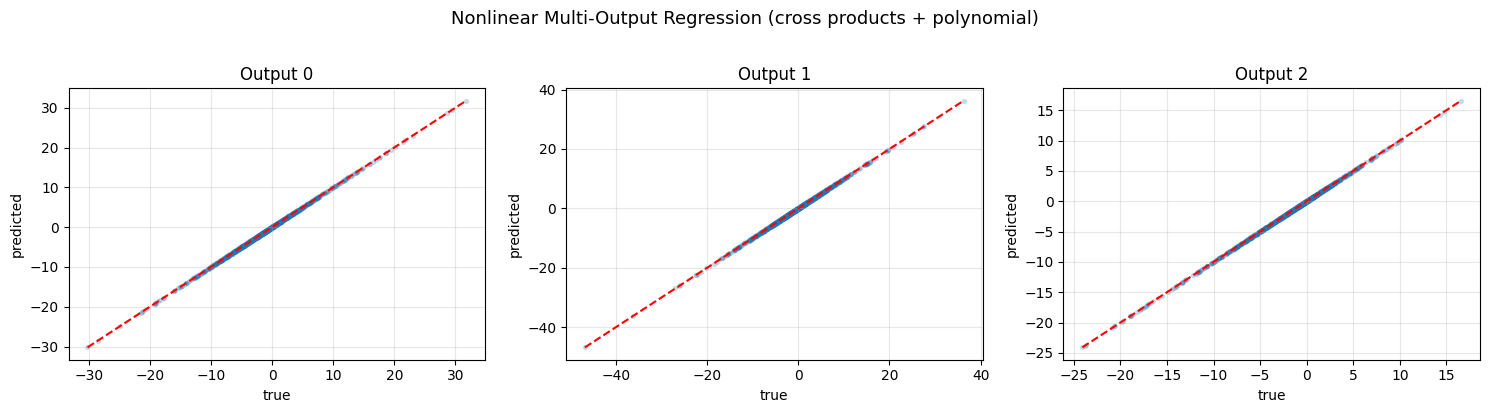

In [8]:
fig, axes = plt.subplots(1, n_outputs_cp, figsize=(5 * n_outputs_cp, 4))

for i in range(n_outputs_cp):
    axes[i].scatter(Y_cp[:, i], Y_pred_cp[:, i], alpha=0.2, s=8)
    lims = [Y_cp[:, i].min(), Y_cp[:, i].max()]
    axes[i].plot(lims, lims, "r--", linewidth=1.5)
    axes[i].set_xlabel("true")
    axes[i].set_ylabel("predicted")
    axes[i].set_title(f"Output {i}")
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Nonlinear Multi-Output Regression (cross products + polynomial)", y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

## 5. Sin-Cos Cross Dictionary

Use `dictionary_sin_cos_cross` for modelling trigonometric interactions between features.

In [9]:
n_inputs_sc = 4
n_samples = 1000
n_outputs_sc = 2

x_sc = rng.standard_normal((n_samples, n_inputs_sc))

x_const_sc    = AILibs.common.dictionary.dictionary_constant(x_sc)
x_sin_cos_cr  = AILibs.common.dictionary.dictionary_sin_cos_cross(x_sc)
x_aug_sc      = numpy.concatenate([x_sc, x_const_sc, x_sin_cos_cr], axis=1)

print(f"Original features:   {n_inputs_sc}")
print(f"sin_cos_cross terms: {x_sin_cos_cr.shape[1]}")
print(f"Total augmented:     {x_aug_sc.shape[1]}")

A_true_sc = rng.standard_normal((x_aug_sc.shape[1], n_outputs_sc))
# sparsify: keep only 30% non-zero
A_true_sc[rng.random(A_true_sc.shape) < 0.7] = 0.0
Y_sc = x_aug_sc @ A_true_sc

# fit with lr_fit (dense)
A_est_sc = AILibs.linear_regression.lr_fit(x_aug_sc, Y_sc)
Y_pred_sc = x_aug_sc @ A_est_sc

metrics_sc = AILibs.metrics.regression_evaluation(Y_sc, Y_pred_sc)
print(f"\nR² = {metrics_sc['r2']:.6f}")

Original features:   4
sin_cos_cross terms: 24
Total augmented:     29

R² = 1.000000


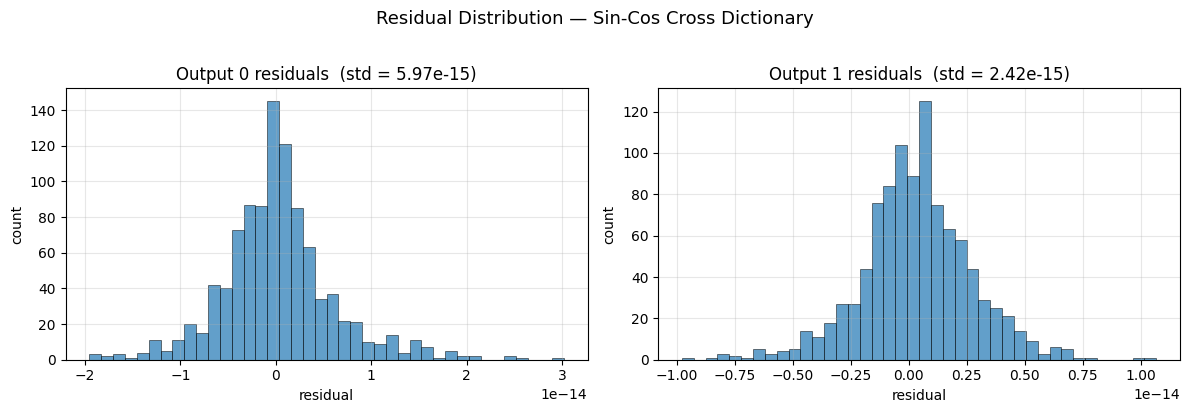

In [10]:
# residual distribution
residuals = Y_sc - Y_pred_sc

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i in range(n_outputs_sc):
    axes[i].hist(residuals[:, i], bins=40, alpha=0.7, edgecolor="black", linewidth=0.5)
    axes[i].set_xlabel("residual")
    axes[i].set_ylabel("count")
    axes[i].set_title(f"Output {i} residuals  (std = {residuals[:, i].std():.2e})")
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Residual Distribution — Sin-Cos Cross Dictionary", y=1.02, fontsize=13)
plt.tight_layout()
plt.show()